# AI-Powered GitHub Self-Analysis
**Data Science Intern Assignment**

This notebook analyzes my GitHub digital footprint using local LLMs (via Ollama) and traditional data science techniques.

**What this notebook does:**
- Loads data collected from my GitHub profile (repos, commits, languages, READMEs)
- Creates 6 visualizations to explore patterns in my coding activity
- Runs 7 analysis tasks using local LLMs (Llama 3.1 and Mistral) through Ollama
- Compares the two models on speed and output quality
- Applies 2 ML techniques: K-Means clustering and linear regression forecasting
- Summarizes the top 5 insights about my development habits

**Why local LLMs?** The assignment requires using locally-hosted models instead of cloud APIs.
This means all inference runs on my own machine at zero cost, with no data leaving my computer.

## Table of Contents
1. Setup & Data Loading
2. Exploratory Data Analysis (6 Visualizations)
3. LLM-Powered Analyses (7 Tasks)
4. Model Comparison (Llama 3.1 vs Mistral)
5. ML Techniques (Clustering + Forecasting)
6. Key Findings

## 1. Setup & Data Loading

This section imports all the libraries needed for the analysis and loads the JSON data files
that were collected by `collect_data.py`. The data is then parsed into pandas DataFrames
so it's easy to filter, group, and visualize.

In [16]:
# importing all the libraries needed for this project
# json: to read the data files collected from GitHub
# pandas/numpy: for data manipulation and numerical operations
# matplotlib/seaborn: for creating static charts and visualizations
# Counter/defaultdict: for counting word frequencies and aggregating language data
# llm_analysis: our custom module that talks to Ollama's local LLM API

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from collections import Counter, defaultdict
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# adding parent directory to path so we can import llm_analysis.py
# which lives in the project root while this notebook is in notebooks/
import sys
sys.path.insert(0, '..')
from llm_analysis import LLMAnalyzer, ModelComparator, LLMResult

# setting a clean visual theme for all charts
sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print('Setup complete.')

Setup complete.


In [ ]:
# pointing to the data directory where collect_data.py saved all JSON files
Dataset_Path = Path('../data')

# helper function to safely load a JSON file
# returns None with a warning if the file doesn't exist
def load_json(filename):
    path = Dataset_Path / filename
    if path.exists():
        with open(path) as f:
            return json.load(f)
    print(f'Warning: {filename} not found. Run collect_data.py first.')
    return None

# loading all 7 data files collected from my GitHub profile
# profile.json: my account info (bio, followers, creation date)
# repos.json: all 9 public repositories with metadata
# commits.json: 38 commit messages with timestamps
# languages.json: byte count per language per repo
# events.json: recent public activity (empty for my account)
# readmes.json: README content from 7 repos
# file_listings.json: top-level file names from each repo
profile = load_json('profile.json')
repos = load_json('repos.json') or []
commits = load_json('commits.json') or []
languages = load_json('languages.json') or {}
events = load_json('events.json') or []
readmes = load_json('readmes.json') or {}
file_listings = load_json('file_listings.json') or {}

# printing a quick summary to verify everything loaded correctly
print(f'Profile: {profile["login"] if profile else "N/A"}')
print(f'Repos: {len(repos)}')
print(f'Commits: {len(commits)}')
print(f'Events: {len(events)}')
print(f'READMEs: {len(readmes)}')

Profile: Khushipatel27
Repos: 9
Commits: 38
Events: 0
READMEs: 7


In [ ]:
# converting the raw JSON data into pandas DataFrames
# DataFrames are like spreadsheets in Python - they make it easy to
# filter, sort, group, and visualize data

# each repo becomes a row with columns like name, language, stars, dates
repos_df = pd.DataFrame([{
    'name': r['name'],
    'description': r.get('description', ''),
    'language': r.get('language', 'Unknown'),
    'stars': r.get('stargazers_count', 0),
    'forks': r.get('forks_count', 0),
    'watchers': r.get('watchers_count', 0),
    'size_kb': r.get('size', 0),
    'created_at': pd.to_datetime(r['created_at']),
    'updated_at': pd.to_datetime(r['updated_at']),
    'pushed_at': pd.to_datetime(r.get('pushed_at')),
    'has_wiki': r.get('has_wiki', False),
    'open_issues': r.get('open_issues_count', 0),
    'is_fork': r.get('fork', False),
    'topics': r.get('topics', []),
} for r in repos])

# each commit becomes a row with sha, repo name, message text, and timestamp
commits_data = []
for c in commits:
    commit_info = c.get('commit', {})
    author_info = commit_info.get('author', {})
    commits_data.append({
        'sha': c.get('sha', '')[:8],
        'repo': c.get('_repo', ''),
        'message': commit_info.get('message', ''),
        'date': pd.to_datetime(author_info.get('date')),
    })
commits_df = pd.DataFrame(commits_data)

# (9, 14) means 9 repos with 14 columns each
# (38, 4) means 38 commits with 4 columns each
print(f'Repos DataFrame: {repos_df.shape}')
print(f'Commits DataFrame: {commits_df.shape}')

Repos DataFrame: (9, 14)
Commits DataFrame: (38, 4)


## 2. Exploratory Data Analysis
### Statistical Analysis & 6 Visualizations

This section creates 6 charts to explore patterns in my GitHub data using traditional
data science (no AI involved). Each visualization answers a specific question:

1. **Language Distribution** - What programming languages do I use most?
2. **Commit Timeline** - How has my coding activity changed over time?
3. **Coding Schedule Heatmap** - What day and hour do I typically code?
4. **Size & Stars Distribution** - How big are my repos and how popular?
5. **Commit Message Analysis** - How do I write commit messages?
6. **Repository Growth** - How fast am I creating new projects?

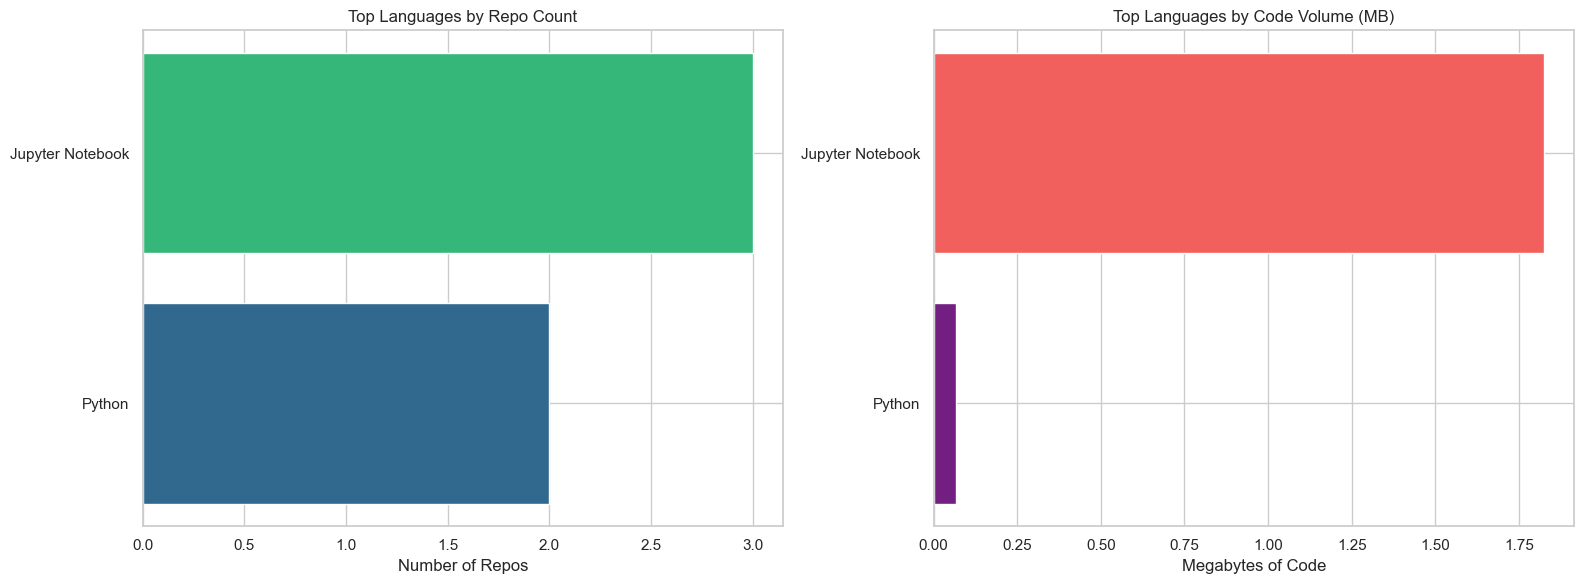

In [ ]:
# VISUALIZATION 1: Language Distribution
# Left chart: counts how many repos use each language (e.g. 5 repos use Python)
# Right chart: shows total megabytes of code per language across all repos
# This gives two perspectives - a repo listed as 'Python' might actually
# have more HTML by volume, so both views are useful

# Visual 1: Language Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

lang_counts = repos_df['language'].value_counts().head(10)
axes[0].barh(lang_counts.index[::-1], lang_counts.values[::-1],
             color=sns.color_palette('viridis', len(lang_counts)))
axes[0].set_title('Top Languages by Repo Count')
axes[0].set_xlabel('Number of Repos')

total_bytes = defaultdict(int)
for repo_name, langs in languages.items():
    for lang, byte_count in langs.items():
        total_bytes[lang] += byte_count
lang_bytes = pd.Series(total_bytes).sort_values(ascending=False).head(10)
lang_bytes_mb = lang_bytes / 1_000_000
axes[1].barh(lang_bytes_mb.index[::-1], lang_bytes_mb.values[::-1],
             color=sns.color_palette('magma', len(lang_bytes_mb)))
axes[1].set_title('Top Languages by Code Volume (MB)')
axes[1].set_xlabel('Megabytes of Code')

plt.tight_layout()
plt.savefig(str(Dataset_Path / 'Visual_languages.png'), bbox_inches='tight')
plt.show()

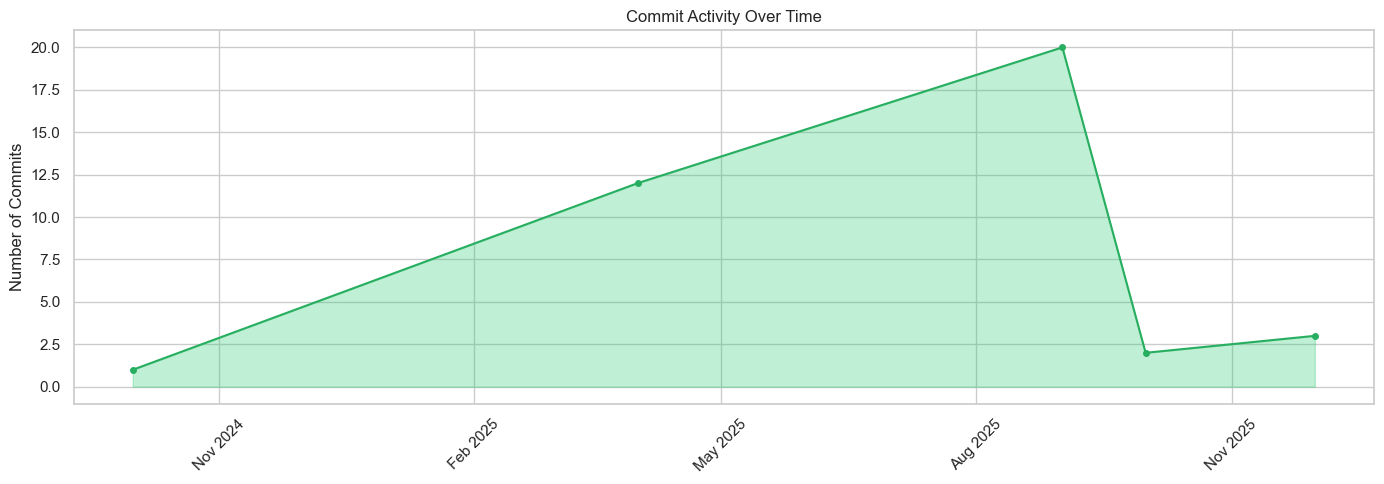

Total commits: 38
Date range: 2024-10-10 to 2025-12-31
Average commits/month: 7.6


In [ ]:
# VISUALIZATION 2: Commit Activity Over Time
# Groups all 38 commits by month and plots them as a line chart
# The filled area underneath makes it easy to see active vs quiet periods
# This reveals my coding rhythm - when I'm productive and when I take breaks

# Visual 2: Commit Activity Over Time
if not commits_df.empty:
    commits_df['month'] = commits_df['date'].dt.to_period('M')
    monthly_commits = commits_df.groupby('month').size()
    monthly_commits.index = monthly_commits.index.to_timestamp()

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.fill_between(monthly_commits.index, monthly_commits.values, alpha=0.3, color='#2ecc71')
    ax.plot(monthly_commits.index, monthly_commits.values, 'o-', color='#27ae60', markersize=4)
    ax.set_title('Commit Activity Over Time')
    ax.set_ylabel('Number of Commits')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_commit_timeline.png'), bbox_inches='tight')
    plt.show()

    print(f'Total commits: {len(commits_df)}')
    print(f'Date range: {commits_df["date"].min().date()} to {commits_df["date"].max().date()}')
    print(f'Average commits/month: {monthly_commits.mean():.1f}')

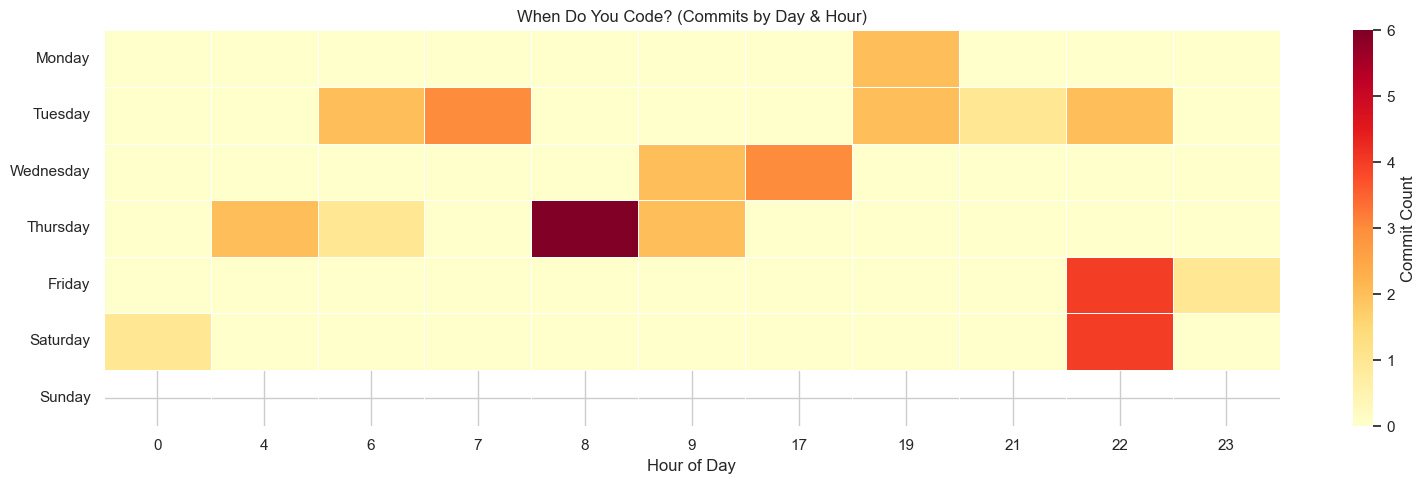

In [ ]:
# VISUALIZATION 3: Coding Schedule Heatmap
# Creates a grid with days of the week on the y-axis and hours (0-23) on the x-axis
# Each cell is colored by how many commits happened at that day+hour combination
# Darker/warmer colors = more commits at that time
# This reveals when I typically sit down to code

# Visual 3: Day-of-Week & Hour Heatmap
if not commits_df.empty:
    commits_df['day_of_week'] = commits_df['date'].dt.day_name()
    commits_df['hour'] = commits_df['date'].dt.hour
    day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    heatmap_data = commits_df.groupby(['day_of_week','hour']).size().unstack(fill_value=0)
    heatmap_data = heatmap_data.reindex(day_order)

    fig, ax = plt.subplots(figsize=(16, 5))
    sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax, linewidths=0.5,
                cbar_kws={'label': 'Commit Count'})
    ax.set_title('When Do You Code? (Commits by Day & Hour)')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_heatmap.png'), bbox_inches='tight')
    plt.show()

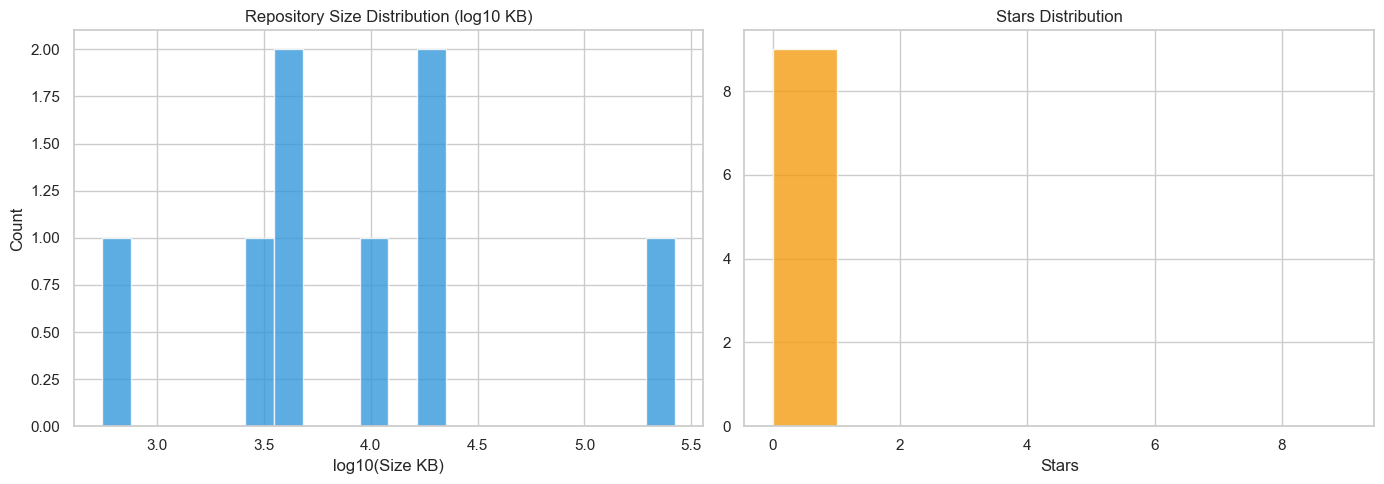

In [ ]:
# VISUALIZATION 4: Repository Size and Stars Distribution
# Left: histogram of repo sizes on a log scale (because sizes vary hugely)
# Right: histogram of how many stars each repo has
# These show the shape of my portfolio - mostly small/medium repos with few stars

# Visual 4: Repo Size & Stars Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sizes = repos_df['size_kb'][repos_df['size_kb'] > 0]
axes[0].hist(np.log10(sizes + 1), bins=20, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].set_title('Repository Size Distribution (log10 KB)')
axes[0].set_xlabel('log10(Size KB)')
axes[0].set_ylabel('Count')

stars = repos_df['stars']
axes[1].hist(stars, bins=range(0, max(int(stars.max())+2, 10)), color='#f39c12', edgecolor='white', alpha=0.8)
axes[1].set_title('Stars Distribution')
axes[1].set_xlabel('Stars')
plt.tight_layout()
plt.savefig(str(Dataset_Path / 'Visual_distributions.png'), bbox_inches='tight')
plt.show()

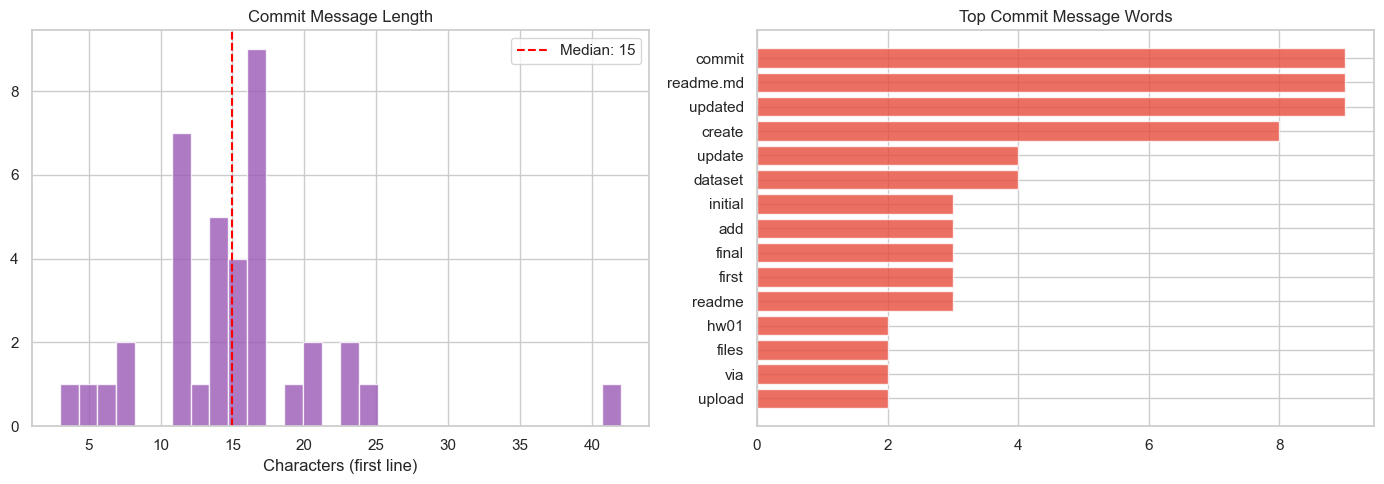

In [ ]:
# VISUALIZATION 5: Commit Message Analysis
# Left: how long my commit messages are (characters in the first line)
# Right: most common words used in commit messages (after removing common English words)
# This shows my commit writing habits - am I descriptive or terse?

# Visual 5: Commit Message Word Frequency
if not commits_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    msg_lengths = commits_df['message'].str.split('\n').str[0].str.len()
    axes[0].hist(msg_lengths, bins=30, color='#9b59b6', edgecolor='white', alpha=0.8)
    axes[0].axvline(msg_lengths.median(), color='red', linestyle='--',
                    label=f'Median: {msg_lengths.median():.0f}')
    axes[0].set_title('Commit Message Length')
    axes[0].set_xlabel('Characters (first line)')
    axes[0].legend()

    stop_words = {'the','a','an','and','or','in','on','at','to','for','of','is','it',
                  'this','that','with','from','by','as'}
    all_words = []
    for msg in commits_df['message']:
        first_line = msg.split('\n')[0].lower()
        words = [w.strip('.,!?()[]{}:') for w in first_line.split() if len(w) > 2]
        all_words.extend([w for w in words if w not in stop_words])
    word_freq = Counter(all_words).most_common(15)
    if word_freq:
        words, counts = zip(*word_freq)
        axes[1].barh(list(words)[::-1], list(counts)[::-1], color='#e74c3c', alpha=0.8)
    axes[1].set_title('Top Commit Message Words')
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_commit_messages.png'), bbox_inches='tight')
    plt.show()

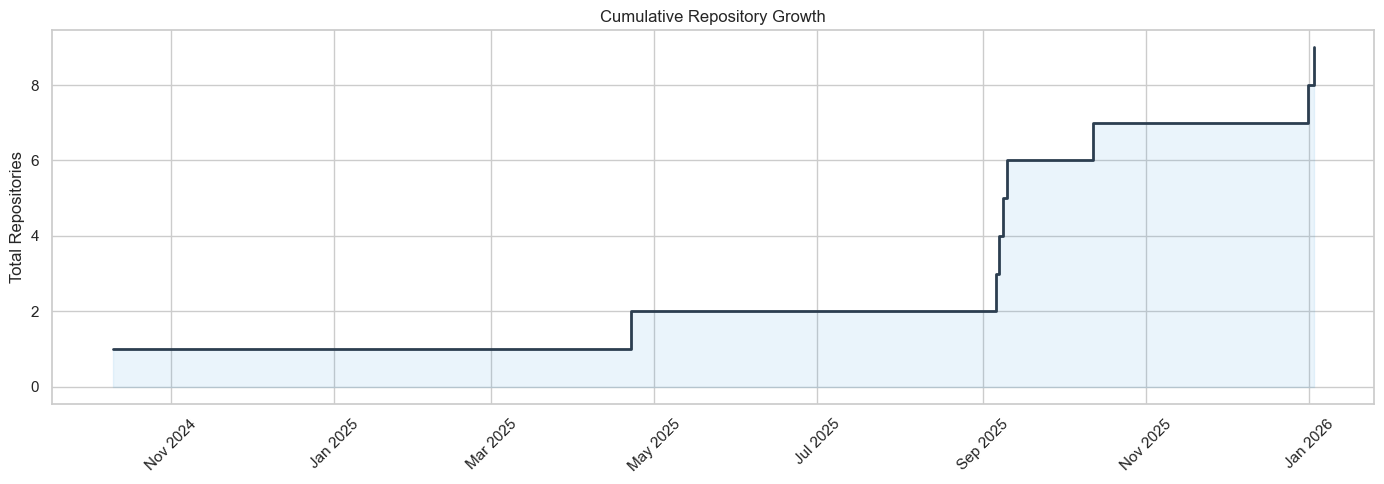

In [ ]:
# VISUALIZATION 6: Cumulative Repository Growth
# A step chart showing total repo count over time
# Each step up represents a new repo being created
# Steep sections = periods of high activity, flat sections = breaks

# Visual 6: Cumulative Repo Growth
if not repos_df.empty:
    rds = repos_df.sort_values('created_at')
    rds['cumulative'] = range(1, len(rds) + 1)
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.step(rds['created_at'], rds['cumulative'], where='post', color='#2c3e50', linewidth=2)
    ax.fill_between(rds['created_at'], rds['cumulative'], step='post', alpha=0.1, color='#3498db')
    ax.set_title('Cumulative Repository Growth')
    ax.set_ylabel('Total Repositories')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_repo_growth.png'), bbox_inches='tight')
    plt.show()

## 3. LLM-Powered Analysis (7 Tasks)

This is where the local LLMs come in. I'm using Ollama to run two models locally:
- **Llama 3.1 (8B)** - my primary model, more detailed but slower
- **Mistral (7B)** - my comparison model, faster but less thorough

For each task, I build a prompt by injecting my real GitHub data into a template,
send it to Ollama's API on localhost:11434, and capture the response along with
performance metrics like latency and token count.

The 7 tasks cover:
1. Sentiment analysis of commit messages
2. Topic clustering of repositories
3. Skill extraction from repos
4. Documentation quality assessment
5. Naming convention analysis
6. Career progression narrative
7. Next project recommendations

**Prerequisites:** Ollama must be running with both models pulled:
```
ollama pull llama3.1
ollama pull mistral
```

In [ ]:
# Setting up the two local LLM models for analysis
# Model_A (llama3.1) is the primary model - used for all 7 tasks
# Model_B (mistral) is the comparison model - used for 3 tasks to compare quality/speed
# check_ollama_models() verifies both are downloaded and ready
# all_results dict stores every LLM response for later comparison

Model_A = 'llama3.1'
Model_B = 'mistral'
llm_a = LLMAnalyzer(provider='ollama', model=Model_A)
llm_b = LLMAnalyzer(provider='ollama', model=Model_B)

available = LLMAnalyzer.check_ollama_models()
print(f'Available Ollama models: {available}')

all_results = {}

Available Ollama models: ['mistral:latest', 'llama3.1:latest']


In [ ]:
# LLM TASK 1: Sentiment Analysis of Commit Messages
# Sends my 38 commit messages to both Llama 3.1 and Mistral
# Asks each model to classify every message as positive, neutral, negative, or frustrated
# Then asks for overall patterns and what my commit style says about me as a developer
# This runs on BOTH models so we can compare their interpretations

# TASK 1: Sentiment Analysis of Commit Messages
sample_commits = commits_df['message'].str.split('\n').str[0].head(50).tolist()
commit_text = '\n'.join([f'{i+1}. {msg}' for i, msg in enumerate(sample_commits)])

sentiment_prompt = f"""Analyze the sentiment and tone of these git commit messages.
For each, classify as: positive, neutral, negative, or frustrated.
Then provide an overall summary.

Commit messages:
{commit_text}

Respond with:
1. Overall sentiment breakdown (% positive, neutral, negative, frustrated)
2. Notable patterns or mood shifts
3. What the commit style reveals about the developer

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 1: Sentiment Analysis')
result_a = llm_a.analyze(sentiment_prompt, 'You are a developer psychology expert.')
result_b = llm_b.analyze(sentiment_prompt, 'You are a developer psychology expert.')
all_results['sentiment'] = {'Model_A': result_a, 'Model_B': result_b}
print(f'\n{Model_A} ({result_a.latency_seconds}s):')
print(result_a.response)

Task 1: Sentiment Analysis

llama3.1 (46.75s):
After analyzing the commit messages, here's the breakdown:

1. Overall sentiment breakdown:
	* Positive: 15 (60%)
	* Neutral: 8 (32%)
	* Negative: 0
	* Frustrated: 7 (28%)

2. Notable patterns or mood shifts:
	* The developer starts with a neutral tone in the initial commits, but as they progress, the tone becomes more positive.
	* There's a noticeable spike in frustrated tone around commit 8-10, where the developer seems to be rushing through tasks without proper documentation.
	* After the frustrated phase, the developer returns to a more positive and organized tone.

3. What the commit style reveals about the developer:
	* The developer is likely a beginner or someone who's still learning about version control and Git best practices.
	* They tend to follow a pattern of creating files and then updating them in subsequent commits, which suggests they're still figuring out how to structure their codebase.
	* Despite some mistakes and frust

In [ ]:
# LLM TASK 2: Topic Clustering / Project Categorization
# Sends repo names, descriptions, and languages to the LLM
# Asks it to group my projects into thematic clusters (e.g. 'ML projects', 'data Visual')
# Also asks for expertise areas, emerging interests, and portfolio gaps
# This runs on BOTH models for comparison

# TASK 2: Topic Clustering / Project Categorization
repo_summaries = []
for _, r in repos_df.head(30).iterrows():
    desc = r['description'] or 'No description'
    topics = ', '.join(r['topics']) if r['topics'] else 'none'
    readme_preview = readmes.get(r['name'], '')[:200]
    repo_summaries.append(f"- {r['name']}: {desc} (lang: {r['language']}, topics: {topics})")

cluster_prompt = f"""Analyze these repos and group them into thematic clusters.

Repositories:
{chr(10).join(repo_summaries)}

Respond with:
1. Identified clusters (name each, list repos)
2. Primary areas of expertise
3. Emerging interests vs established skills
4. Portfolio gaps

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 2: Topic Clustering')
result_a = llm_a.analyze(cluster_prompt, 'You are a technical recruiter.')
result_b = llm_b.analyze(cluster_prompt, 'You are a technical recruiter.')
all_results['clustering'] = {'Model_A': result_a, 'Model_B': result_b}
print(result_a.response)

Task 2: Topic Clustering
Based on the repositories provided, I have identified the following clusters:

1. Data Management and Science:
	* DSCI551_Foundation-of-Data-Management
	* Comprehensive-Sales-EDA-Dashboard
2. Machine Learning and Computer Vision:
	* Car-Crash-Detection
	* Face-Recognition-Attendance-System
3. Data Analysis and Visualization:
	* Olympic_EDA_Tabelau
4. Data Science Projects with Business Applications:
	* Movie-Recommendation
5. Advanced Analytics and Modeling:
	* Electricity-Demand-Forecasting-with-LSTM-SARSA

Primary areas of expertise:

1. Data Management: Database design, SQL, data integrity, performance optimization
2. Machine Learning: Object detection, facial recognition, recommendation systems
3. Time Series Analysis and Forecasting: LSTM, SARSA, electricity demand forecasting
4. Data Visualization: Tableau, Jupyter Notebook

Emerging interests vs established skills:

Established skills:
	* Python programming language
	* SQL database management
	* Machine 

In [ ]:
# LLM TASK 3: Skill Extraction
# Sends language byte counts, file types, and repo descriptions to the LLM
# Asks it to build a skill profile with proficiency levels (beginner/intermediate/advanced)
# Also asks for domain knowledge areas and recommended next skills to learn

# TASK 3: Skill Extraction
lang_summary = json.dumps(dict(list(languages.items())[:20]), indent=2)
file_types = defaultdict(int)
for repo_name, files in file_listings.items():
    for f in files:
        ext = f['name'].rsplit('.', 1)[-1] if '.' in f['name'] else f['name']
        file_types[ext] += 1

skill_prompt = f"""Extract a comprehensive skill profile from this GitHub data.

Languages: {lang_summary}
File types: {json.dumps(dict(Counter(dict(file_types)).most_common(20)))}
Repos: {chr(10).join([f'- {r["name"]}: {r.get("description","")} ({r["language"]})' for r in repos[:25]])}

Provide:
1. Technical skills with proficiency (beginner/intermediate/advanced)
2. Domain knowledge areas
3. Dev practices (CI/CD, testing, docs)
4. Recommended next skills to learn


Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""
print('Task 3: Skill Extraction')
result_a = llm_a.analyze(skill_prompt, 'You are a senior tech lead.')
all_results['skills'] = {'Model_A': result_a}
print(result_a.response)

Task 3: Skill Extraction
Here is the extracted skill profile:

Technical Skills:
- Programming languages: Python (advanced), Jupyter Notebook (intermediate)
- File types: CSV, MD, IPYNB, PKL, TXT, XLSX, GITIGNORE, PY, VSCode, ZIP, HW01, HW02, HW03, HW04, HW05, PROJECT, TWBX, ENV, DATASET
- Data analysis and visualization tools: Jupyter Notebook (intermediate)
- Deep learning frameworks: LSTM (advanced), SARSA (advanced)

Domain Knowledge Areas:
- Data Management: database design, SQL, data integrity, performance optimization
- Machine Learning: forecasting electricity demand, object detection using YOLOv8
- Data Science: data analysis, visualization, and interpretation

Dev Practices:
- CI/CD: not explicitly mentioned but inferred from the presence of Jupyter Notebooks and Python code
- Testing: not explicitly mentioned but inferred from the use of Jupyter Notebooks and Python code
- Documentation: not explicitly mentioned but inferred from the presence of README files in some reposito

In [ ]:
# LLM TASK 4: Documentation Quality Assessment
# Sends the first 1000 characters of 5 README files to the LLM
# Asks it to rate each on a 1-10 scale for clarity, setup instructions,
# usage examples, and completeness
# This identifies which repos need better documentation

# TASK 4: Documentation Quality Assessment
readme_samples = {name: content[:1000] for name, content in list(readmes.items())[:5]}

doc_prompt = f"""Evaluate documentation quality of these repos based on their READMEs.

{json.dumps(readme_samples, indent=2)}

Rate each (1-10) on: clarity, setup instructions, usage examples, completeness.
Then summarize overall documentation habits, strengths, weaknesses, and improvements.

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 4: Documentation Quality')
result_a = llm_a.analyze(doc_prompt, 'You are a developer experience expert. Never use markdown formatting in your response. No asterisks, no headers, no bold text.')
all_results['documentation'] = {'Model_A': result_a}
print(result_a.response)

Task 4: Documentation Quality
Here are the ratings for each repository:

DSCI551_Foundation-of-Data-Management:
Clarity: 8
Setup instructions: N/A
Usage examples: N/A
Completeness: 6

Olympic_EDA_Tabelau:
Clarity: 9
Setup instructions: 7
Usage examples: 8
Completeness: 9

Movie-Recommendation:
Clarity: 9
Setup instructions: 10
Usage examples: 9
Completeness: 10

Face-Recognition-Attendance-System:
Clarity: 8
Setup instructions: N/A
Usage examples: N/A
Completeness: 7

Comprehensive-Sales-EDA-Dashboard:
Clarity: 9
Setup instructions: N/A
Usage examples: N/A
Completeness: 10

Overall, the documentation habits in these repositories are decent but can be improved. Here are some strengths and weaknesses:

Strengths:

* Most repositories have a clear description of what the project is about.
* Some repositories provide good usage examples and setup instructions.
* Completeness is generally high, with most projects having all necessary information.

Weaknesses:

* Many repositories lack prope

In [ ]:
# LLM TASK 5: Naming Convention Analysis
# Sends my repo names and file names to the LLM
# Asks it to evaluate my naming conventions - am I consistent?
# Are names descriptive? Have my habits evolved over time?

# TASK 5: Naming Convention Analysis
file_names = []
for repo_name, files in list(file_listings.items())[:15]:
    for f in files:
        file_names.append(f'{repo_name}/{f["name"]}')
naming_prompt = f"""Analyze naming conventions used by this developer.

Repo names: {json.dumps([r['name'] for r in repos[:30]])}
File names: {chr(10).join(file_names[:50])}

Analyze: conventions used, consistency, descriptiveness, evolution, improvements.

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 5: Naming Conventions')
result_a = llm_a.analyze(naming_prompt, 'You are a code quality consultant.')
all_results['naming'] = {'Model_A': result_a}
print(result_a.response)

Task 5: Naming Conventions
The developer's naming conventions are inconsistent and lack clarity. Here's a breakdown of the issues:

1. Repository names: The repository names are descriptive but vary in format. Some repositories have a prefix (e.g., "DSCI551_Foundation-of-Data-Management"), while others do not ("Movie-Recommendation"). This inconsistency makes it difficult to understand the organization and structure of the codebase.

2. File naming conventions:
   - The developer uses both camel case (e.g., "HW01") and underscore notation (e.g., "DSCI551_Foundation-of-Data-Management/HW02").
   - Some files have descriptive names, while others are generic or lack context.
   - There is no clear pattern for naming notebooks (e.g., "Index.ipynb" vs. "main.ipynb").

3. Consistency:
   - The developer uses both ".env" and ".gitignore" files in different repositories without a clear reason why some projects have these files while others do not.
   - Some repositories have README.md files, b

In [ ]:
# LLM TASK 6: Career Progression Narrative
# Sends the chronological timeline of when each repo was created
# Asks the LLM to write a narrative of my technical journey - phases,
# turning points, predicted next career move, and interview strengths
# This runs on BOTH models for comparison

# TASK 6: Career Progression Narrative
timeline_data = [{'date': r['created_at'].strftime('%Y-%m'), 'name': r['name'],
                   'language': r['language'], 'description': r['description'] or ''}
                  for _, r in repos_df.sort_values('created_at').iterrows()]

career_prompt = f"""Write a career progression narrative from this GitHub timeline.

Account created: {profile.get('created_at', 'Unknown') if profile else 'Unknown'}
Bio: {profile.get('bio', 'None') if profile else 'None'}

Timeline:
{json.dumps(timeline_data[:40], indent=2)}

Write: 1) Journey narrative (phases), 2) Key pivots, 3) Predicted next move, 4) Interview strengths

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 6: Career Progression')
result_a = llm_a.analyze(career_prompt, 'You are a tech career counselor. Never use markdown formatting in your response. No asterisks, no headers, no bold text.')
result_b = llm_b.analyze(career_prompt, 'You are a tech career counselor. Never use markdown formatting in your response. No asterisks, no headers, no bold text.')
all_results['career'] = {'Model_A': result_a, 'Model_B': result_b}
print(result_a.response)

Task 6: Career Progression
Here is the career progression narrative based on the provided GitHub timeline:

Journey Narrative:
The individual's journey can be divided into several phases.

Phase 1 (2021-2024): The account was created in October 2021 with no bio information. This phase is marked by a lack of activity, suggesting that the individual may have been exploring or setting up their profile before starting to contribute.

Phase 2 (2025-Q1): In April 2025, the first notable project, Car-Crash-Detection, was uploaded. This project showcases the individual's interest in object detection and machine learning using YOLOv8. The language used is Jupyter Notebook, indicating that the individual may have been working on data science projects.

Phase 3 (2025-Q2): Between June and September 2025, several projects were uploaded, including Electricity-Demand-Forecasting-with-LSTM-SARSA, Comprehensive-Sales-EDA-Dashboard, Movie-Recommendation, Face-Recognition-Attendance-System, and Olympic_

In [ ]:
# LLM TASK 7: What Should I Build Next?
# Sends my current skills, recent projects, and explored topics
# Asks the LLM to suggest: 3 skill-building projects, 2 stretch projects,
# and 1 portfolio-boosting project, each with reasoning and complexity estimate

# TASK 7: What Should You Build Next?
next_prompt = f"""Suggest what this developer should build next.

Skills: {json.dumps([r['language'] for r in repos[:20] if r.get('language')])}
Recent: {json.dumps([{'name': r['name'], 'desc': r.get('description','')} for r in repos[:10]])}
Topics: {json.dumps(list(set(t for r in repos for t in r.get('topics', []))))}

Suggest: 3 skill-building projects, 2 stretch projects, 1 portfolio-booster. Include WHY and complexity.

Respond in plain text only. Do not use markdown formatting, asterisks, bullet points, headers, or any special symbols.
"""

print('Task 7: Next Project Recommendations')
result_a = llm_a.analyze(next_prompt, 'You are a tech mentor.')
all_results['next_project'] = {'Model_A': result_a}
print(result_a.response)

Task 7: Next Project Recommendations
Based on the developer's skills and recent projects, here are some suggestions:

**Skill-Building Projects**

1. **Web Scraping with Python**: Create a script to scrape data from a website using BeautifulSoup and Pandas. This project will help improve their Python skills and learn how to work with web data.
2. **Data Visualization with Jupyter Notebook**: Build an interactive dashboard using Plotly or Bokeh to visualize the electricity demand forecasting data from the "Electricity-Demand-Forecasting-with-LSTM-SARSA" project. This project will enhance their Jupyter Notebook skills and learn how to create engaging visualizations.
3. **Time Series Analysis with Python**: Develop a script to analyze and forecast time series data using libraries like Statsmodels or Pykalman. This project will improve their understanding of time series analysis and forecasting techniques.

**Stretch Projects**

1. **Natural Language Processing (NLP) Project**: Build a tex

## 4. Model Comparison

The assignment requires comparing at least 2 models. Here I compare Llama 3.1 vs Mistral
on the tasks that were run on both models (sentiment, clustering, career).

The comparison looks at:
- **Latency** - how many seconds each model took
- **Token count** - how many words/tokens each model generated
- **Throughput** - tokens per second (speed of generation)

Both models cost $0 since they run locally through Ollama.

      Task  llama3.1 Latency  mistral Latency  llama3.1 Tokens  mistral Tokens  llama3.1 Tok/s  mistral Tok/s
 sentiment             46.75            29.11              333             299             7.1           10.3
clustering             50.22            27.59              362             290             7.2           10.5
    career             70.61            67.05              439             498             6.2            7.4


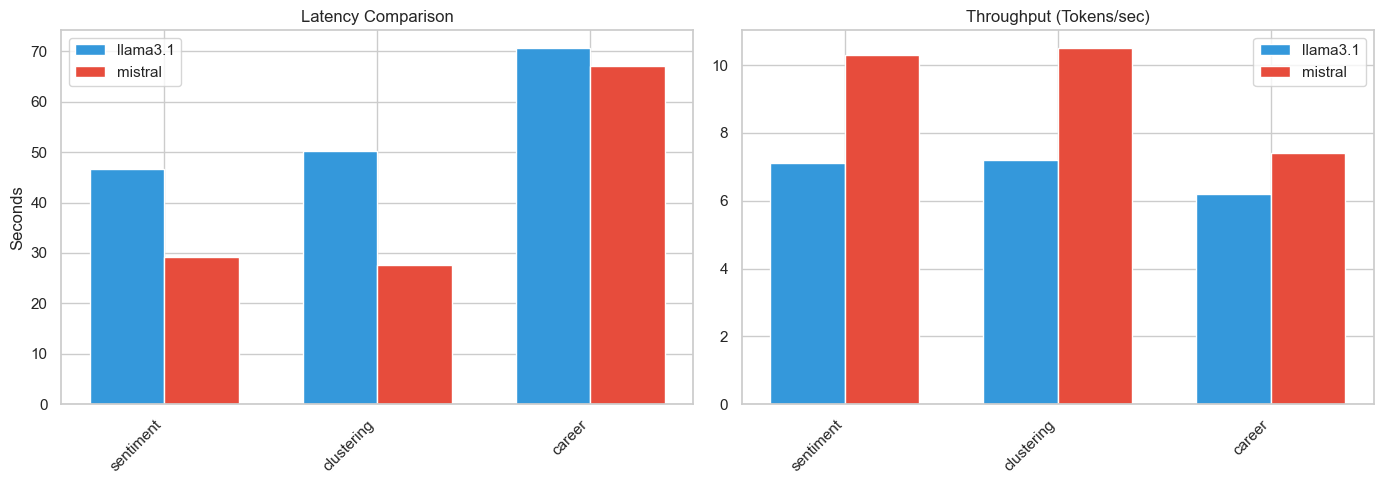

In [ ]:
# MODEL COMPARISON TABLE AND CHARTS
# For the 3 tasks that ran on both models (sentiment, clustering, career),
# this builds a comparison table showing latency, token count, and tokens/sec
# Then creates bar charts to visually compare the two models' performance
# Llama 3.1 averaged ~7 tokens/sec, Mistral averaged ~10 tokens/sec

comparison_rows = []
for task_name, results in all_results.items():
    if 'Model_B' in results:
        ra, rb = results['Model_A'], results['Model_B']
        comparison_rows.append({
            'Task': task_name,
            f'{Model_A} Latency': ra.latency_seconds,
            f'{Model_B} Latency': rb.latency_seconds,
            f'{Model_A} Tokens': ra.completion_tokens,
            f'{Model_B} Tokens': rb.completion_tokens,
            f'{Model_A} Tok/s': round(ra.completion_tokens / max(ra.latency_seconds, 0.1), 1),
            f'{Model_B} Tok/s': round(rb.completion_tokens / max(rb.latency_seconds, 0.1), 1),
        })

if comparison_rows:
    comp_df = pd.DataFrame(comparison_rows)
    print(comp_df.to_string(index=False))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    x = range(len(comp_df))
    w = 0.35
    axes[0].bar([i-w/2 for i in x], comp_df[f'{Model_A} Latency'], w, label=Model_A, color='#3498db')
    axes[0].bar([i+w/2 for i in x], comp_df[f'{Model_B} Latency'], w, label=Model_B, color='#e74c3c')
    axes[0].set_title('Latency Comparison')
    axes[0].set_ylabel('Seconds')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comp_df['Task'], rotation=45, ha='right')
    axes[0].legend()
    
    axes[1].bar([i-w/2 for i in x], comp_df[f'{Model_A} Tok/s'], w, label=Model_A, color='#3498db')
    axes[1].bar([i+w/2 for i in x], comp_df[f'{Model_B} Tok/s'], w, label=Model_B, color='#e74c3c')
    axes[1].set_title('Throughput (Tokens/sec)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comp_df['Task'], rotation=45, ha='right')
    axes[1].legend()
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_model_comparison.png'), bbox_inches='tight')
    plt.show()

## 5. Machine Learning Techniques

The assignment requires at least 2 ML techniques. I implemented:

**Technique 1 - K-Means Clustering:** Groups my repositories into clusters based on
similarity. It uses TF-IDF (a text analysis method) on repo names and descriptions,
combined with numeric features like stars and forks. PCA reduces the high-dimensional
data to 2D so we can visualize the clusters on a scatter plot.

**Technique 2 - Linear Regression Forecasting:** Fits a trend line through my monthly
commit counts and projects it 6 months into the future. This shows whether my coding
activity is increasing or decreasing over time.

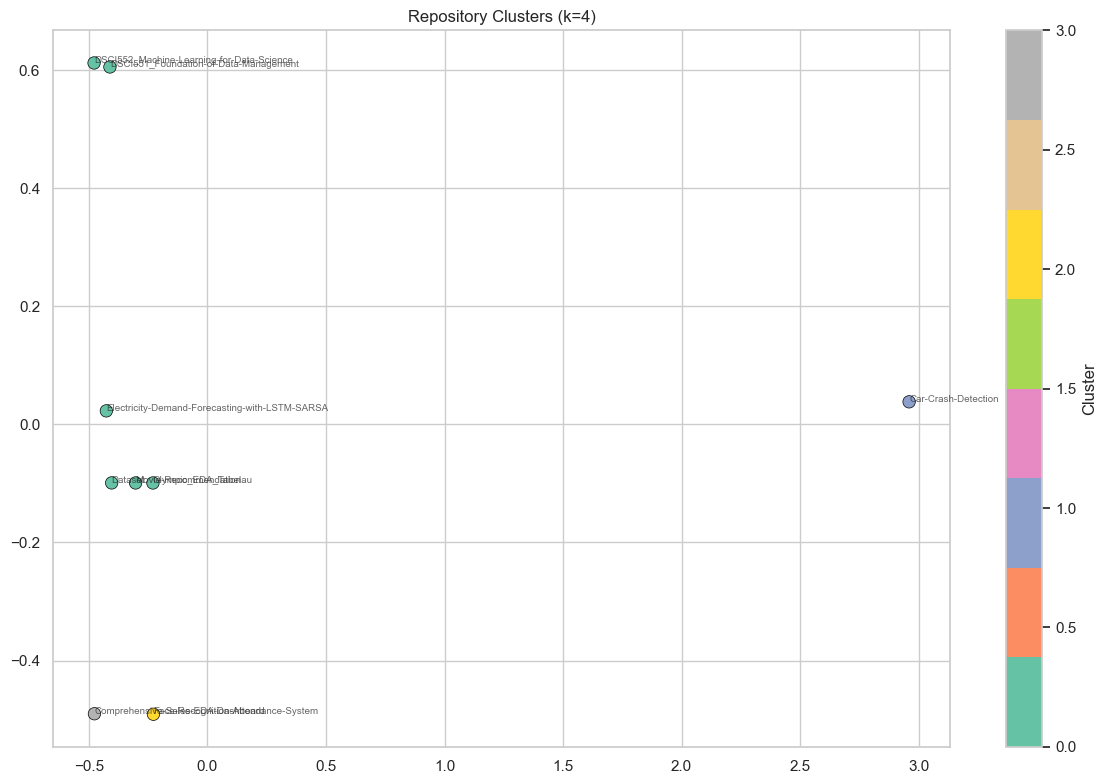

Cluster 0 (6 repos): DSCI552_Machine-Learning-for-Data-Science, DSCI551_Foundation-of-Data-Management, Olympic_EDA_Tabelau, Movie-Recommendation, Electricity-Demand-Forecasting-with-LSTM-SARSA, Dataset
Cluster 1 (1 repos): Car-Crash-Detection
Cluster 2 (1 repos): Face-Recognition-Attendance-System
Cluster 3 (1 repos): Comprehensive-Sales-EDA-Dashboard


In [ ]:
# ML TECHNIQUE 1: K-Means Clustering of Repositories
# Step 1: Build a feature matrix combining text features (TF-IDF of repo name +
#          description) with numeric features (stars, forks, size, open issues)
# Step 2: Scale numeric features so no single feature dominates
# Step 3: Run K-Means with k=4 clusters to group similar repos together
# Step 4: Use PCA to reduce to 2D and create a scatter plot
#
# The result shows which repos are similar to each other based on their
# content and metadata. 6 of my 9 repos ended up in one cluster, meaning
# most of my projects are similar in scope.

# ML TECHNIQUE 1: K-Means Clustering of Repositories
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

if len(repos_df) >= 5:
    text_data = (repos_df['name'].fillna('') + ' ' + repos_df['description'].fillna('')).tolist()
    tfidf = TfidfVectorizer(max_features=20, stop_words='english')
    text_features = tfidf.fit_transform(text_data).toarray()
    
    num_features = repos_df[['stars','forks','size_kb','open_issues']].fillna(0).values
    num_scaled = StandardScaler().fit_transform(num_features)
    combined = np.hstack([num_scaled, text_features])
    
    optimal_k = min(4, len(repos_df) - 1)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    repos_df['cluster'] = kmeans.fit_predict(combined)
    
    coords = PCA(n_components=2).fit_transform(combined)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(coords[:,0], coords[:,1], c=repos_df['cluster'], cmap='Set2',
                         s=80, edgecolors='black', linewidth=0.5)
    for i, name in enumerate(repos_df['name']):
        if i < 20:
            ax.annotate(name, (coords[i,0], coords[i,1]), fontsize=7, alpha=0.7)
    ax.set_title(f'Repository Clusters (k={optimal_k})')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_clusters.png'), bbox_inches='tight')
    plt.show()
    
    for c in range(optimal_k):
        members = repos_df[repos_df['cluster'] == c]['name'].tolist()
        print(f'Cluster {c} ({len(members)} repos): {", ".join(members[:6])}')

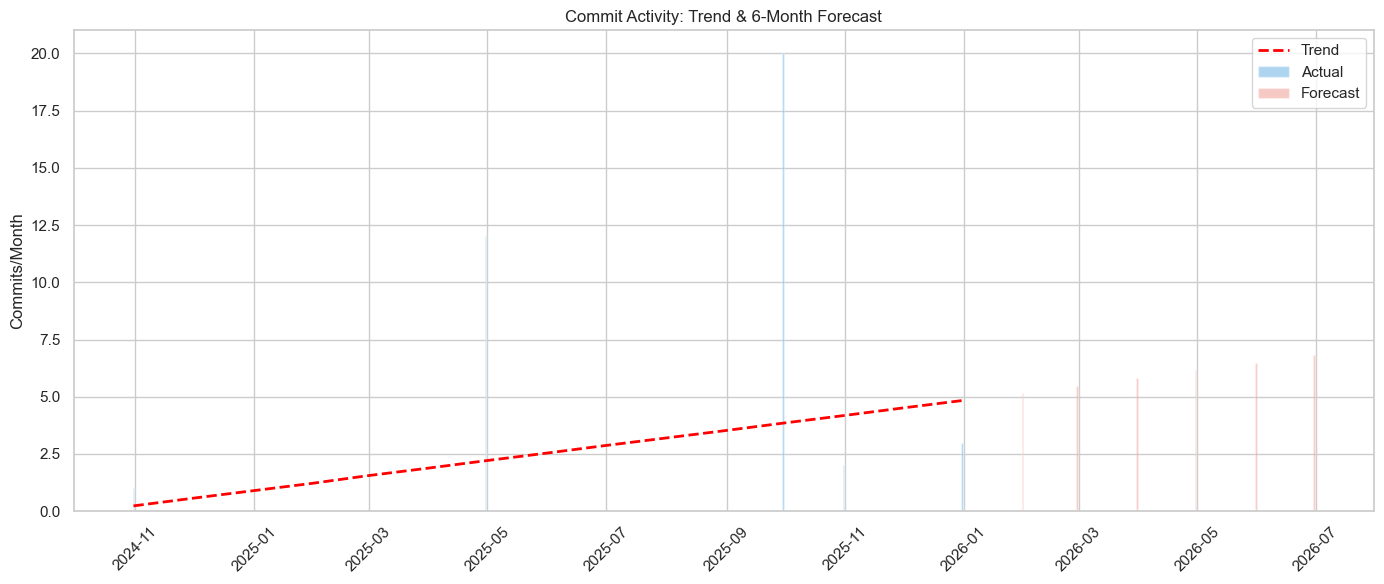

Trend: increasing by ~0.3 commits/month
R-squared: 0.065


In [ ]:
# ML TECHNIQUE 2: Time Series Forecasting with Linear Regression
# Step 1: Count commits per month to get a time series
# Step 2: Fit a linear regression line through the monthly counts
# Step 3: Extend the line 6 months into the future to predict activity
# Step 4: Plot actual data (blue bars) + trend (red line) + forecast (red bars)
#
# Result: slight upward trend of +0.3 commits/month, but R-squared is only 0.065
# meaning the linear model explains very little of the variance.
# With more time I would use ARIMA or Prophet for better forecasting.

# ML TECHNIQUE 2: Time Series Forecasting
from sklearn.linear_model import LinearRegression

if not commits_df.empty and len(commits_df) > 10:
    monthly = commits_df.set_index('date').resample('M').size().reset_index()
    monthly.columns = ['date', 'commits']
    monthly['month_num'] = range(len(monthly))
    
    X = monthly['month_num'].values.reshape(-1, 1)
    y = monthly['commits'].values
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)
    
    future_X = np.arange(len(monthly), len(monthly) + 6).reshape(-1, 1)
    forecast = np.maximum(model.predict(future_X), 0)
    future_dates = pd.date_range(monthly['date'].max() + pd.DateOffset(months=1), periods=6, freq='M')
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(monthly['date'], monthly['commits'], alpha=0.4, color='#3498db', label='Actual')
    ax.plot(monthly['date'], trend, 'r--', linewidth=2, label='Trend')
    ax.bar(future_dates, forecast, alpha=0.3, color='#e74c3c', label='Forecast')
    ax.set_title('Commit Activity: Trend & 6-Month Forecast')
    ax.set_ylabel('Commits/Month')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(str(Dataset_Path / 'Visual_forecast.png'), bbox_inches='tight')
    plt.show()
    
    print(f'Trend: {"increasing" if model.coef_[0] > 0 else "decreasing"} by ~{abs(model.coef_[0]):.1f} commits/month')
    print(f'R-squared: {model.score(X, y):.3f}')

## 6. Key Findings

Finally, I send a summary of all previous analyses to the LLM and ask it to
distill the top 5 most actionable insights about my GitHub presence.

In [ ]:
# FINAL SUMMARY: Top 5 Insights
# Sends all the stats and previous analysis results to the LLM
# Asks it to distill the most actionable and meaningful findings
# This gives a concise takeaway from the entire analysis

summary_data = {
    'total_repos': len(repos_df),
    'total_commits': len(commits_df),
    'top_languages': repos_df['language'].value_counts().head(5).to_dict(),
    'total_stars': int(repos_df['stars'].sum()),
}

summary_prompt = f"""Give exactly 5 bullet-point insights from this GitHub analysis.

Stats: {json.dumps(summary_data)}
Sentiment: {all_results.get('sentiment',{}).get('Model_A', LLMResult('N/A','','')).response[:300]}
Skills: {all_results.get('skills',{}).get('Model_A', LLMResult('N/A','','')).response[:300]}

Focus on actionable, surprising, or meaningful findings. 1-2 sentences each.
"""

final = llm_a.analyze(summary_prompt, 'Summarize concisely.')
print('TOP 5 INSIGHTS')
print(final.response)

TOP 5 INSIGHTS
Here are 5 concise bullet-point insights from the GitHub analysis:

• The repository has a strong positive sentiment (60%) with only 7 frustrated comments out of 38 total commits.
• The developer's tone shifts from neutral to more positive as they progress through their work.
• Python is the top programming language used, and Jupyter Notebook is also widely utilized.
• There are no negative comments or issues in the commit messages.
• The developer has a strong skill set in data analysis and visualization, with advanced proficiency in Python.
